# Stimulus Image Classifier

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from src.dataset.kay import load_dataset
from src.utils.util import prepare_stimulus_data

from src.ml import StimulusClassifierConfig

from src.ml.test import test_model
from src.ml.train import train_model
from src.ml.model import StimulusClassifier
from src.ml.dataset import StimulusDataset, create_weighted_sampler, calculate_mean_std
from src.ml.utils import plot_loss_acc_curves, generate_score_report, get_class_weights
from src.ml.sweep import train_all_stim_models

In [2]:
%matplotlib inline

sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

title_size = 16
params = {
    "legend.fontsize": 14,
    "axes.labelsize": title_size - 2,
    "axes.titlesize": title_size,
    "xtick.labelsize": title_size - 4,
    "ytick.labelsize": title_size - 4,
    "axes.titlepad": 1.5 * title_size,
}

plt.rcParams.update(params)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)

We're using => cuda


In [4]:
config = StimulusClassifierConfig()

## Load Data

In [5]:
all_data = load_dataset(data_path="./../data/")

In [6]:
# train data
x_train, y_train = prepare_stimulus_data(
    all_data=all_data,
    data_subset="train",
    class_ignore_list=config.class_ignore_list,
    label_level=config.label_level,
)

# test data
x_test, y_test = prepare_stimulus_data(
    all_data=all_data,
    data_subset="test",
    class_ignore_list=config.class_ignore_list,
    label_level=config.label_level,
)

In [7]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1593, 128, 128), (1593,), (114, 128, 128), (114,))

In [8]:
class2idx = {k: i for i, k in enumerate(np.unique(y_train))}
idx2class = {v: k for k, v in class2idx.items()}
class2idx

{'animal': 0, 'artifact': 1, 'geological formation': 2}

Text(0.5, 1.0, 'class: artifact')

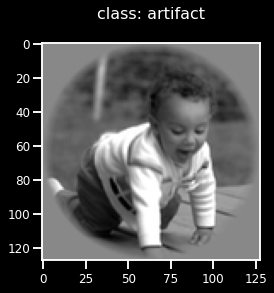

In [9]:
plt.imshow(x_train[0], cmap="gray")
plt.title(f"class: {y_train[0]}")

## Image Transforms

In [10]:
og_dataset = StimulusDataset(
    x_data=x_train,
    y_data=y_train,
    img_transform=config.img_transform["og"],
    class2idx=class2idx,
)

dataset_mean, dataset_std = calculate_mean_std(dataset=og_dataset)

print(f"mean = {dataset_mean}\nstd = {dataset_std}")

  0%|          | 0/1593 [00:00<?, ?it/s]

mean = tensor([0.4583, 0.4583, 0.4583])
std = tensor([0.2172, 0.2172, 0.2172])


## Create Dataset and Dataloader

In [11]:
train_dataset = StimulusDataset(
    x_data=x_train,
    y_data=y_train,
    img_transform=config.img_transform["train"],
    class2idx=class2idx,
)

test_dataset = StimulusDataset(
    x_data=x_test,
    y_data=y_test,
    img_transform=config.img_transform["test"],
    class2idx=class2idx,
)

weighted_sampler = create_weighted_sampler(y_train, class2idx)

train_loader = DataLoader(
    dataset=train_dataset,
    shuffle=False,
    batch_size=config.batch_size,
    sampler=weighted_sampler,
)

test_loader = DataLoader(
    dataset=test_dataset, shuffle=False, batch_size=config.batch_size
)

## Train All Models

  0%|          | 0/5 [00:00<?, ?it/s]

Training vgg-11.



  0%|          | 0/30 [00:00<?, ?it/s]

/home/akshaj/miniconda3/envs/decoding-thoughts/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 01/30: | Train Loss: 1.03284 | Val Loss: 1.23372 | Train Acc: 66.538% | Val Acc: 63.000%
Epoch 02/30: | Train Loss: 0.63109 | Val Loss: 0.88824 | Train Acc: 76.462% | Val Acc: 75.000%
Epoch 03/30: | Train Loss: 0.51697 | Val Loss: 0.78403 | Train Acc: 81.538% | Val Acc: 75.000%
Epoch 04/30: | Train Loss: 0.52006 | Val Loss: 0.79429 | Train Acc: 80.308% | Val Acc: 75.000%
Epoch 05/30: | Train Loss: 0.49703 | Val Loss: 0.74976 | Train Acc: 81.000% | Val Acc: 75.000%
Epoch 06/30: | Train Loss: 0.49491 | Val Loss: 0.81976 | Train Acc: 81.692% | Val Acc: 73.000%
Epoch 07/30: | Train Loss: 0.49682 | Val Loss: 0.90540 | Train Acc: 80.846% | Val Acc: 73.000%
Epoch 08/30: | Train Loss: 0.46059 | Val Loss: 0.96890 | Train Acc: 81.538% | Val Acc: 69.000%
Epoch 09/30: | Train Loss: 0.50260 | Val Loss: 0.95055 | Train Acc: 80.846% | Val Acc: 71.000%
Epoch 10/30: | Train Loss: 0.47896 | Val Loss: 0.89863 | Train Acc: 82.000% | Val Acc: 70.000%
Epoch 11/30: | Train Loss: 0.51980 | Val Loss: 0.8

  0%|          | 0/1 [00:00<?, ?it/s]

Classification Report | vgg-11:

              precision    recall  f1-score   support

           0       0.85      0.72      0.78        54
           1       0.79      0.84      0.82        50
           2       0.47      0.70      0.56        10

    accuracy                           0.77       114
   macro avg       0.70      0.75      0.72       114
weighted avg       0.79      0.77      0.78       114




Training resnet-50.



  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 01/30: | Train Loss: 0.78727 | Val Loss: 1.54950 | Train Acc: 71.538% | Val Acc: 66.000%
Epoch 02/30: | Train Loss: 0.57770 | Val Loss: 1.61831 | Train Acc: 78.000% | Val Acc: 65.000%
Epoch 03/30: | Train Loss: 0.51538 | Val Loss: 1.23982 | Train Acc: 82.308% | Val Acc: 66.000%
Epoch 04/30: | Train Loss: 0.48322 | Val Loss: 1.07275 | Train Acc: 81.462% | Val Acc: 65.000%
Epoch 05/30: | Train Loss: 0.52822 | Val Loss: 0.85541 | Train Acc: 80.077% | Val Acc: 71.000%
Epoch 06/30: | Train Loss: 0.44816 | Val Loss: 0.95006 | Train Acc: 82.692% | Val Acc: 69.000%
Epoch 07/30: | Train Loss: 0.43483 | Val Loss: 1.00675 | Train Acc: 84.077% | Val Acc: 69.000%
Epoch 08/30: | Train Loss: 0.42500 | Val Loss: 1.02139 | Train Acc: 84.308% | Val Acc: 70.000%
Epoch 09/30: | Train Loss: 0.39285 | Val Loss: 1.08984 | Train Acc: 85.154% | Val Acc: 67.000%
Epoch 10/30: | Train Loss: 0.39735 | Val Loss: 1.34396 | Train Acc: 85.385% | Val Acc: 66.000%
Epoch 11/30: | Train Loss: 0.42987 | Val Loss: 1.1

  0%|          | 0/1 [00:00<?, ?it/s]

Classification Report | resnet-50:

              precision    recall  f1-score   support

           0       0.91      0.56      0.69        54
           1       0.69      0.86      0.77        50
           2       0.37      0.70      0.48        10

    accuracy                           0.70       114
   macro avg       0.66      0.71      0.65       114
weighted avg       0.77      0.70      0.71       114




Training resnext50.



  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 01/30: | Train Loss: 0.87256 | Val Loss: 1.71162 | Train Acc: 67.308% | Val Acc: 63.000%
Epoch 02/30: | Train Loss: 0.72911 | Val Loss: 1.04140 | Train Acc: 75.000% | Val Acc: 64.000%
Epoch 03/30: | Train Loss: 0.56730 | Val Loss: 0.98546 | Train Acc: 77.615% | Val Acc: 66.000%
Epoch 04/30: | Train Loss: 0.47140 | Val Loss: 0.86186 | Train Acc: 82.692% | Val Acc: 67.000%
Epoch 05/30: | Train Loss: 0.50709 | Val Loss: 0.87542 | Train Acc: 82.077% | Val Acc: 75.000%
Epoch 06/30: | Train Loss: 0.46096 | Val Loss: 0.78737 | Train Acc: 82.462% | Val Acc: 75.000%
Epoch 07/30: | Train Loss: 0.47187 | Val Loss: 0.82665 | Train Acc: 81.923% | Val Acc: 71.000%
Epoch 08/30: | Train Loss: 0.45953 | Val Loss: 0.91070 | Train Acc: 81.923% | Val Acc: 68.000%
Epoch 09/30: | Train Loss: 0.46096 | Val Loss: 0.91376 | Train Acc: 81.000% | Val Acc: 70.000%
Epoch 10/30: | Train Loss: 0.47920 | Val Loss: 0.70583 | Train Acc: 82.154% | Val Acc: 75.000%
Epoch 11/30: | Train Loss: 0.46243 | Val Loss: 0.8

  0%|          | 0/1 [00:00<?, ?it/s]

Classification Report | resnext50:

              precision    recall  f1-score   support

           0       0.86      0.59      0.70        54
           1       0.70      0.88      0.78        50
           2       0.43      0.60      0.50        10

    accuracy                           0.72       114
   macro avg       0.66      0.69      0.66       114
weighted avg       0.75      0.72      0.72       114




Training mobilenet_v3_large.



  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 01/30: | Train Loss: 4.88913 | Val Loss: 6.19784 | Train Acc: 40.231% | Val Acc: 46.000%
Epoch 02/30: | Train Loss: 1.66804 | Val Loss: 3.03443 | Train Acc: 60.385% | Val Acc: 36.000%
Epoch 03/30: | Train Loss: 1.00163 | Val Loss: 1.61208 | Train Acc: 69.385% | Val Acc: 61.000%
Epoch 04/30: | Train Loss: 0.77903 | Val Loss: 1.19070 | Train Acc: 71.615% | Val Acc: 61.000%
Epoch 05/30: | Train Loss: 0.61803 | Val Loss: 0.99303 | Train Acc: 74.923% | Val Acc: 61.000%
Epoch 06/30: | Train Loss: 0.62298 | Val Loss: 1.07325 | Train Acc: 76.769% | Val Acc: 54.000%
Epoch 07/30: | Train Loss: 0.57524 | Val Loss: 1.30755 | Train Acc: 77.923% | Val Acc: 53.000%
Epoch 08/30: | Train Loss: 0.65758 | Val Loss: 1.33304 | Train Acc: 73.308% | Val Acc: 54.000%
Epoch 09/30: | Train Loss: 0.67049 | Val Loss: 0.84428 | Train Acc: 74.692% | Val Acc: 73.000%
Epoch 10/30: | Train Loss: 0.55903 | Val Loss: 1.00756 | Train Acc: 78.462% | Val Acc: 64.000%
Epoch 11/30: | Train Loss: 0.61163 | Val Loss: 1.2

  0%|          | 0/1 [00:00<?, ?it/s]

Classification Report | mobilenet_v3_large:

              precision    recall  f1-score   support

           0       0.81      0.56      0.66        54
           1       0.66      0.84      0.74        50
           2       0.23      0.30      0.26        10

    accuracy                           0.66       114
   macro avg       0.57      0.57      0.55       114
weighted avg       0.69      0.66      0.66       114




Training densenet121.



  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 01/30: | Train Loss: 0.77899 | Val Loss: 1.28717 | Train Acc: 71.923% | Val Acc: 66.000%
Epoch 02/30: | Train Loss: 0.56560 | Val Loss: 1.66575 | Train Acc: 78.000% | Val Acc: 67.000%
Epoch 03/30: | Train Loss: 0.44951 | Val Loss: 1.40925 | Train Acc: 82.692% | Val Acc: 68.000%
Epoch 04/30: | Train Loss: 0.44240 | Val Loss: 1.23984 | Train Acc: 82.538% | Val Acc: 68.000%
Epoch 05/30: | Train Loss: 0.48101 | Val Loss: 1.10211 | Train Acc: 82.308% | Val Acc: 71.000%
Epoch 06/30: | Train Loss: 0.37908 | Val Loss: 1.15738 | Train Acc: 85.615% | Val Acc: 68.000%
Epoch 07/30: | Train Loss: 0.38146 | Val Loss: 1.12331 | Train Acc: 85.692% | Val Acc: 73.000%
Epoch 08/30: | Train Loss: 0.35273 | Val Loss: 1.30507 | Train Acc: 87.308% | Val Acc: 70.000%
Epoch 09/30: | Train Loss: 0.35516 | Val Loss: 1.25555 | Train Acc: 86.462% | Val Acc: 73.000%
Epoch 10/30: | Train Loss: 0.38273 | Val Loss: 1.26138 | Train Acc: 85.308% | Val Acc: 70.000%
Epoch 11/30: | Train Loss: 0.35522 | Val Loss: 1.3

  0%|          | 0/1 [00:00<?, ?it/s]

Classification Report | densenet121:

              precision    recall  f1-score   support

           0       0.89      0.57      0.70        54
           1       0.72      0.84      0.78        50
           2       0.38      0.80      0.52        10

    accuracy                           0.71       114
   macro avg       0.66      0.74      0.66       114
weighted avg       0.77      0.71      0.72       114






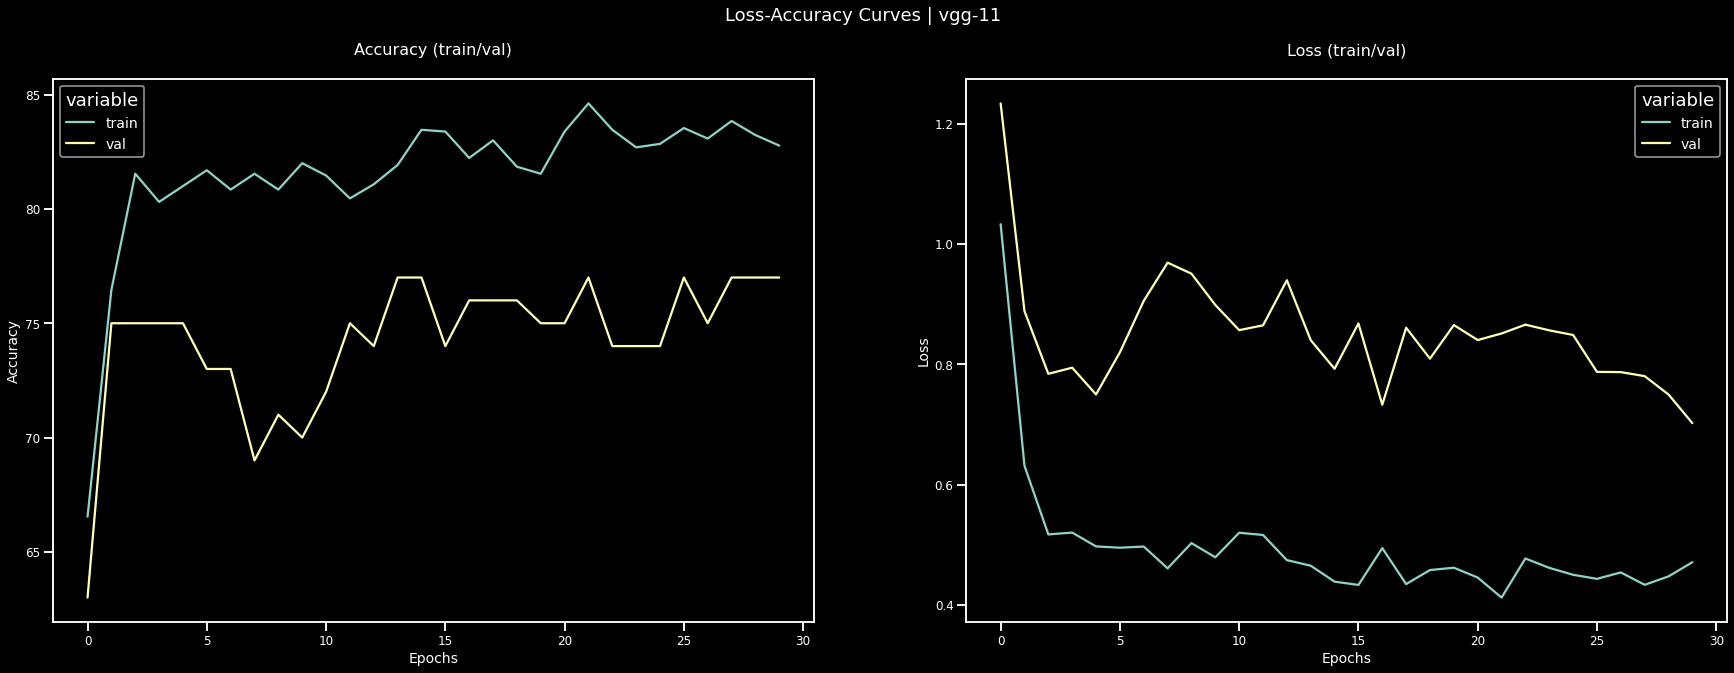

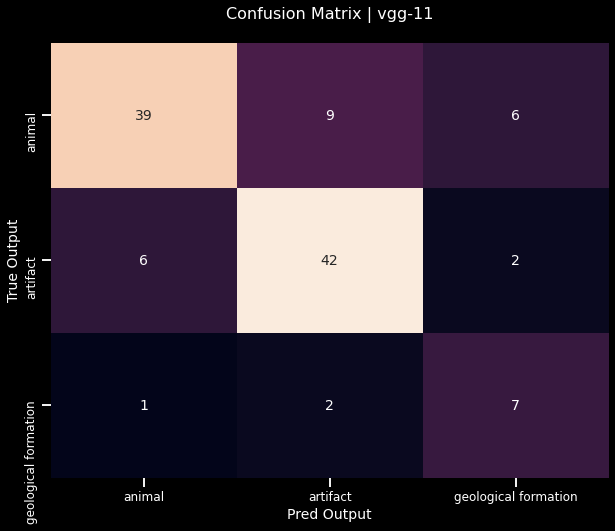

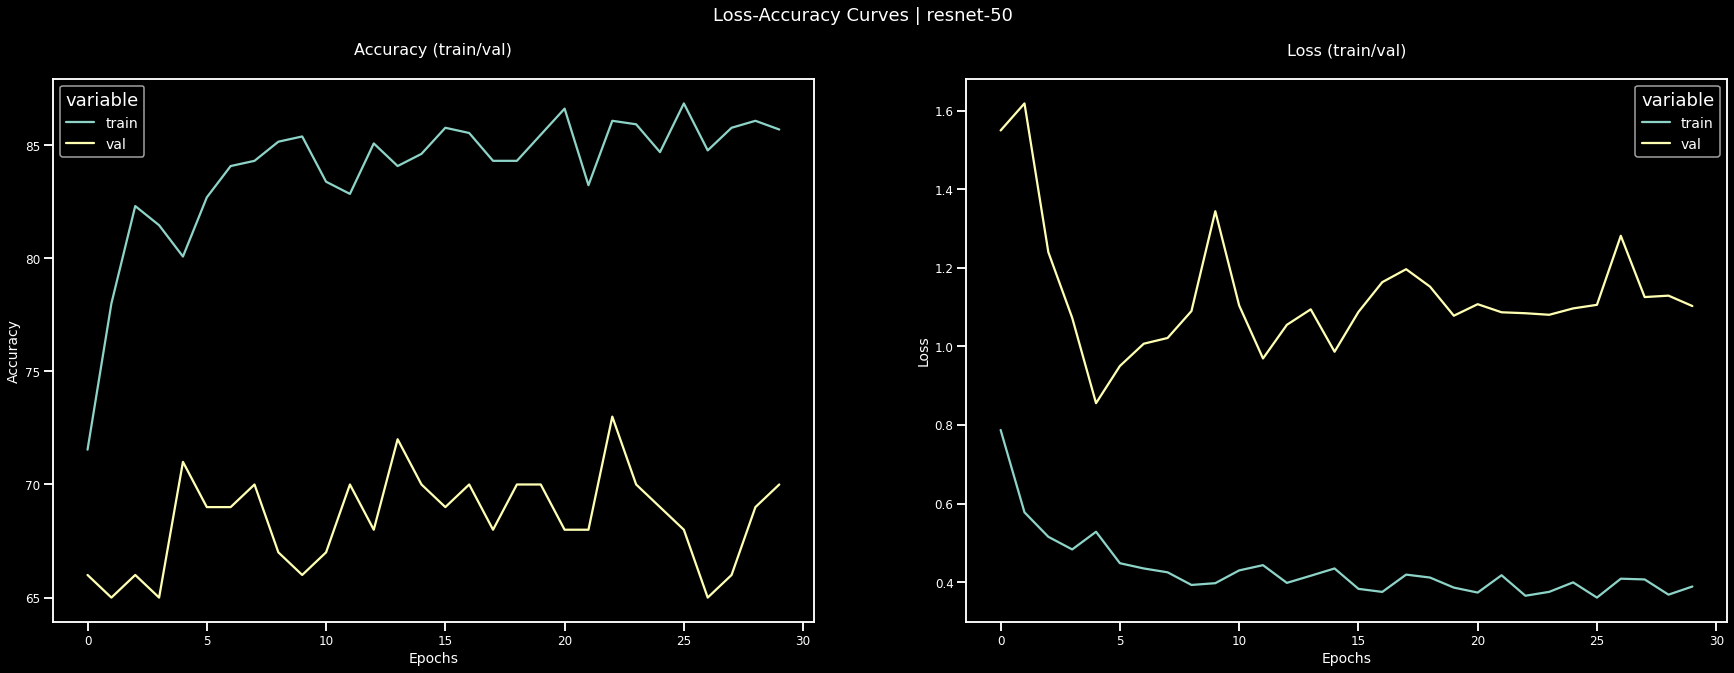

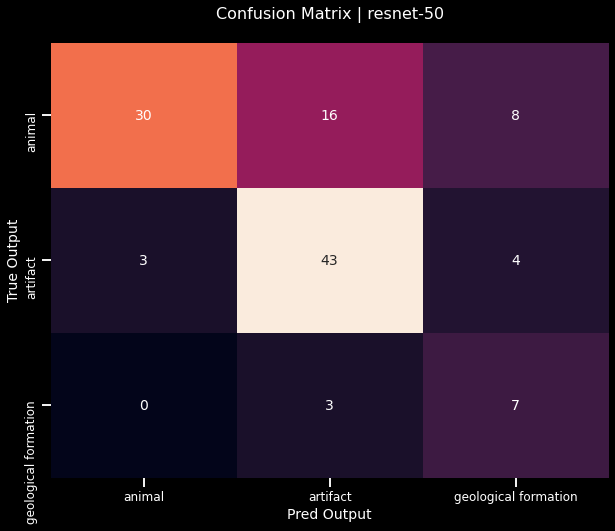

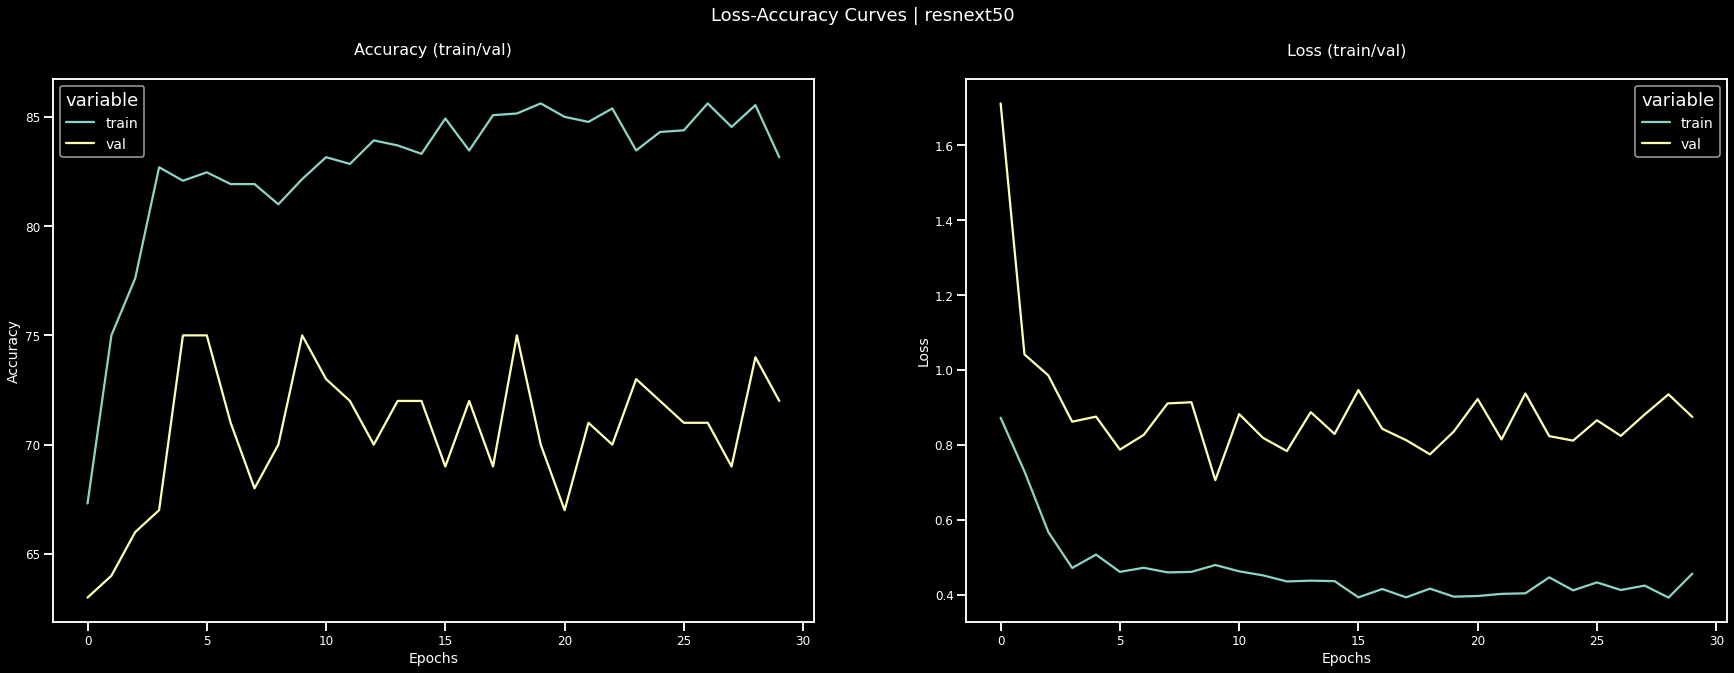

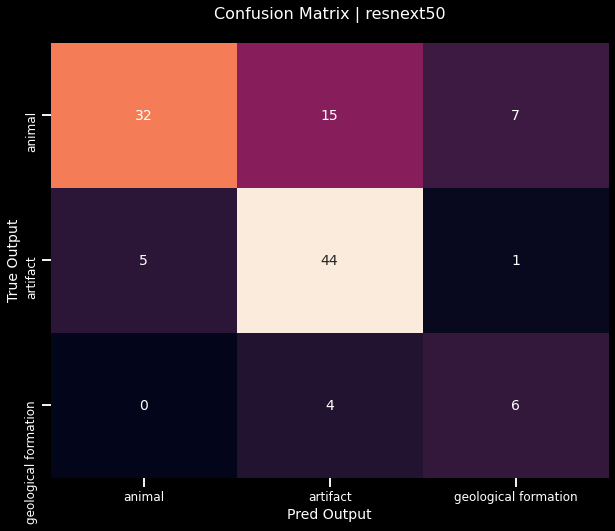

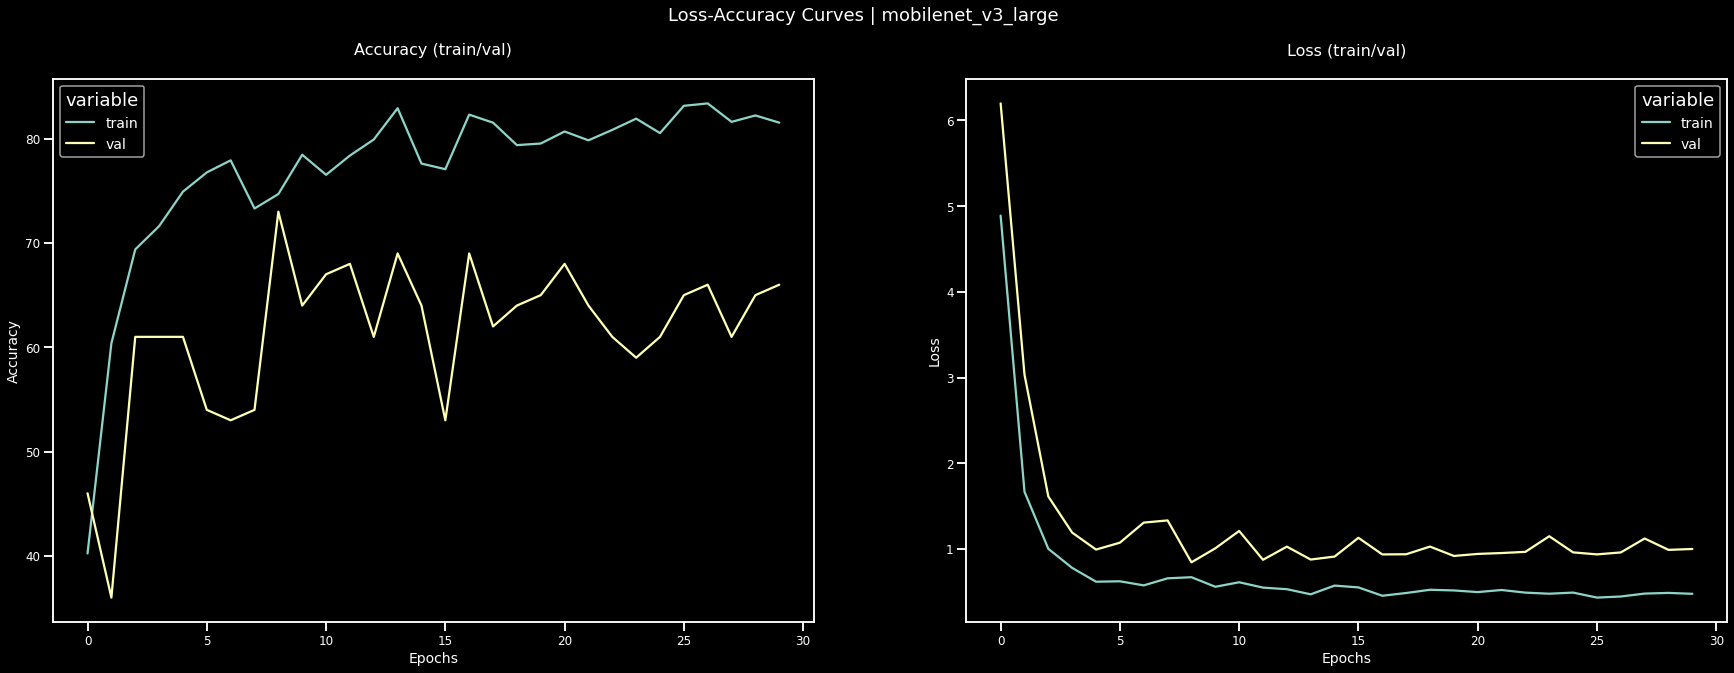

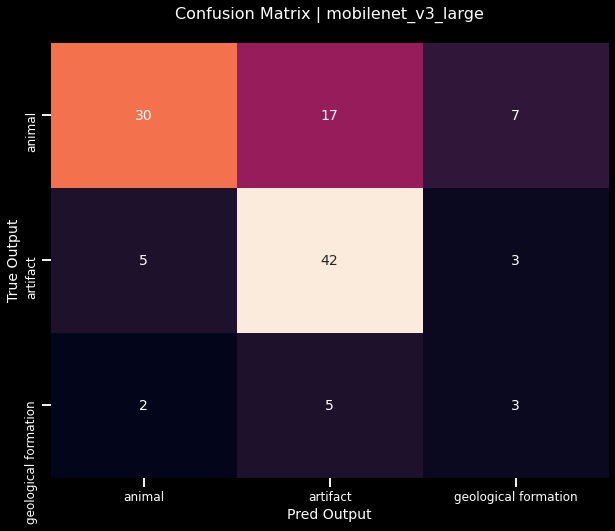

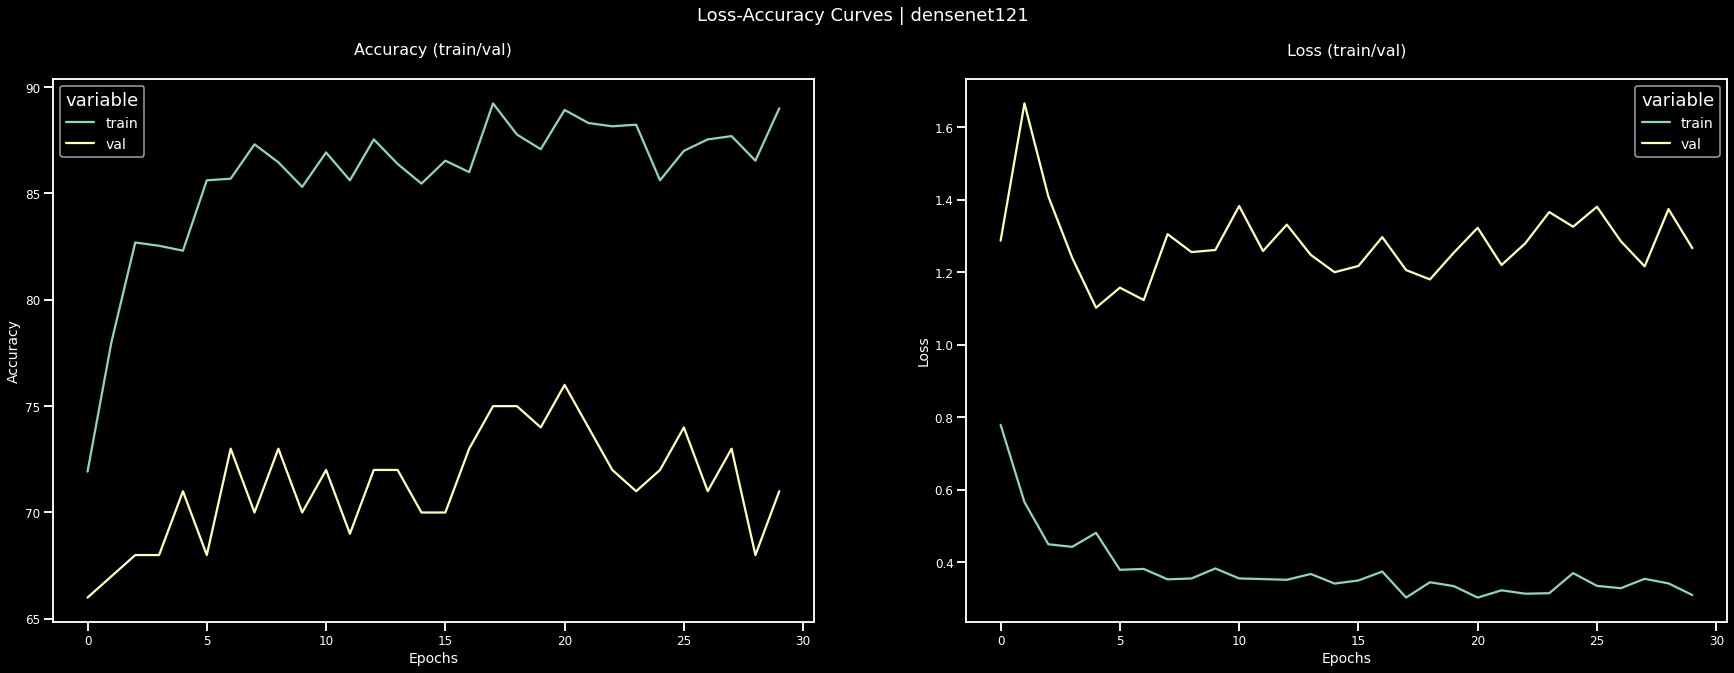

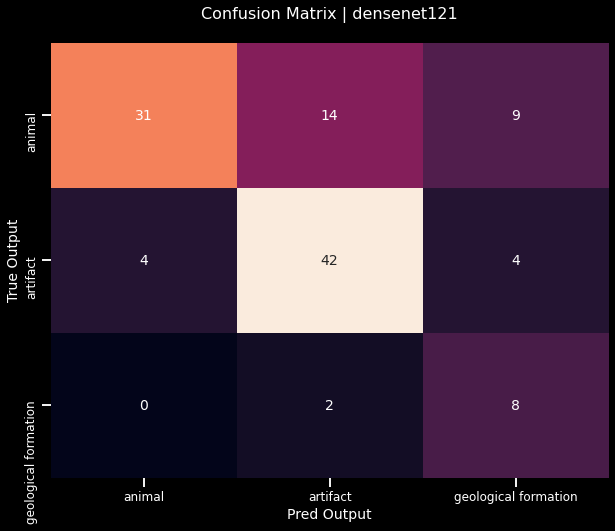

In [12]:
for mn in tqdm(config.model_names):
    print("=" * 50)
    print(f"Training {mn}.\n")
    train_all_stim_models(
        train_loader=train_loader,
        test_loader=test_loader,
        model_name=mn,
        config=config,
        train_model=train_model,
        device=device,
        class2idx=class2idx,
        idx2class=idx2class
    )

    torch.cuda.empty_cache()